<a href="https://colab.research.google.com/github/Alexandre-Data/OC-Projet-7/blob/main/Projet7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.impute import KNNImputer

warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression


In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = False, k=5):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]

    # Utiliser KNNImputer uniquement sur les nouvelles colonnes
    if df[new_columns].isnull().sum().sum() > 0:
      imputer = KNNImputer(n_neighbors=k)
      df[new_columns] = imputer.fit_transform(df[new_columns])

    return df, new_columns

In [3]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    if df['TARGET'].isna().any():
    # Sélectionner uniquement les colonnes numériques
        numeric_cols = df.select_dtypes(include=['number'])

    # Exclure la colonne 'TARGET'
        numeric_cols = numeric_cols.drop(columns=['TARGET'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
        df[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [4]:
essai = application_train_test()
(essai.isna().sum() > 0).sum()

Train samples: 307511, test samples: 48744


1

In [5]:
essai.shape

(356251, 261)

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/bureau_balance.csv', nrows = num_rows)


    threshold = 0.5 * len(bb)
    bb = bb.dropna(thresh=threshold, axis=1)
    threshold1 = 0.5 * len(bureau)
    bureau = bureau.dropna(thresh = threshold1, axis = 1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = bureau.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    bureau[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    # Sélectionner uniquement les colonnes numériques
    numeric_cols1 = bb.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    bb[numeric_cols1.columns] = numeric_cols1.apply(lambda col: col.fillna(col.mean()))


    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')


    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
essai2 = bureau_and_balance()
(essai2.isna().sum() > 0).sum()

61

In [8]:
essai2.shape

(305811, 107)

In [9]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/previous_application.csv', nrows = num_rows)

    threshold = 0.5 * len(prev)
    prev = prev.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = prev.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    prev[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    prev, cat_cols = one_hot_encoder(prev, nan_as_category= False)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [10]:
essai3 = previous_applications()
(essai3.isna().sum() > 0).sum()

52

In [11]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/POS_CASH_balance.csv', nrows = num_rows)

    threshold = 0.5 * len(pos)
    pos = pos.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = pos.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    pos[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))


    pos, cat_cols = one_hot_encoder(pos, nan_as_category= False)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [12]:
essai4 = pos_cash()
(essai4.isna().sum() > 0).sum()

0

In [13]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/installments_payments.csv', nrows = num_rows)

    threshold = 0.5 * len(ins)
    ins = ins.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = ins.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    ins[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    ins, cat_cols = one_hot_encoder(ins, nan_as_category= False)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [14]:
essai5 = installments_payments()
(essai5.isna().sum() > 0).sum()

4

In [15]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/credit_card_balance.csv', nrows = num_rows)

    threshold = 0.5 * len(cc)
    cc = cc.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = cc.select_dtypes(include=['number'])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    cc[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    cc, cat_cols = one_hot_encoder(cc, nan_as_category= False)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [16]:
essai6 = credit_card_balance()
(essai6.isna().sum() > 0).sum()

27

In [17]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [18]:
if __name__ == "__main__":
    with timer("Full model run"):
        # Capture the returned dataframe
        df = main()
    submission_file_name = "/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/fichier_complet.csv"
    df.to_csv(submission_file_name, index=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 107)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 215)
Process previous_applications - done in 25s
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 136)
Process credit card balance - done in 20s
Full model run - done in 127s


In [19]:
df1 = pd.read_csv("/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/fichier_complet.csv")

In [20]:
df1.shape

(356251, 762)

In [21]:
# Calculer le pourcentage de NA pour chaque colonne
na_rate = df1.isna().mean().round(4) * 100

# Supprimer les colonnes avec plus de 50 % de NA
df1 = df.dropna(thresh=len(df)*0.5, axis=1)

In [22]:
df1.shape

(356251, 583)

In [23]:
# Vérifier si le DataFrame contient des valeurs infinies
infinite_values = np.isinf(df1)

# Vérifier si le DataFrame contient au moins une valeur infinie
contains_infinite = infinite_values.any().any()

print("Contient des valeurs infinies:", contains_infinite)


Contient des valeurs infinies: True


In [24]:
# Trouver les colonnes qui contiennent des valeurs infinies
infinite_columns = infinite_values.any()

# Afficher les colonnes avec des valeurs infinies
print("Colonnes avec des valeurs infinies:", infinite_columns[infinite_columns].index.tolist())

Colonnes avec des valeurs infinies: ['PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [25]:
# Trouver les lignes qui contiennent des valeurs infinies
infinite_rows = infinite_values.any(axis=1)

# Compter le nombre de lignes avec des valeurs infinies
num_infinite_rows = infinite_rows.sum()

print("Nombre de lignes avec des valeurs infinies:", num_infinite_rows)


Nombre de lignes avec des valeurs infinies: 57


In [26]:
# Supprimer les lignes avec des valeurs infinies
df_cleaned = df1[~infinite_rows]

In [27]:
# Vérifier si le DataFrame contient des valeurs infinies
infinite_values = np.isinf(df_cleaned)

# Vérifier si le DataFrame contient au moins une valeur infinie
contains_infinite = infinite_values.any().any()

print("Contient des valeurs infinies:", contains_infinite)

Contient des valeurs infinies: False


In [28]:
df_final = df_cleaned.copy()

In [29]:
df_final.isna().sum()

index                                 0
SK_ID_CURR                            0
TARGET                            48727
CODE_GENDER                           0
FLAG_OWN_CAR                          0
                                  ...  
INSTAL_AMT_PAYMENT_SUM            16668
INSTAL_DAYS_ENTRY_PAYMENT_MAX     16668
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    16668
INSTAL_DAYS_ENTRY_PAYMENT_SUM     16668
INSTAL_COUNT                      16668
Length: 583, dtype: int64

<h1 align=center>PARAMETRAGE XGBOOST</h1>

In [30]:
# Garder seulement les lignes où la cible n'est pas NaN
df_cleaned1 = df_cleaned[df_cleaned['TARGET'].notna()]

# Séparation des données en entraînement et test
X = df_cleaned1.drop(columns=['TARGET'])
y = df_cleaned1['TARGET']
X_train_xgb_imp, X_test_xgb_imp, y_train_xgb_imp, y_test_xgb_imp = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model_xgb_imp = XGBClassifier(n_jobs = -1)
model_xgb_imp.fit(X_train_xgb_imp, y_train_xgb_imp)

# Obtenir les importances des caractéristiques et les noms de colonnes
importances = model_xgb_imp.feature_importances_
feature_names = X_train_xgb_imp.columns

# Créer un DataFrame pour les importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Trier par importance
importance_df = importance_df.sort_values(by='importance', ascending=False)


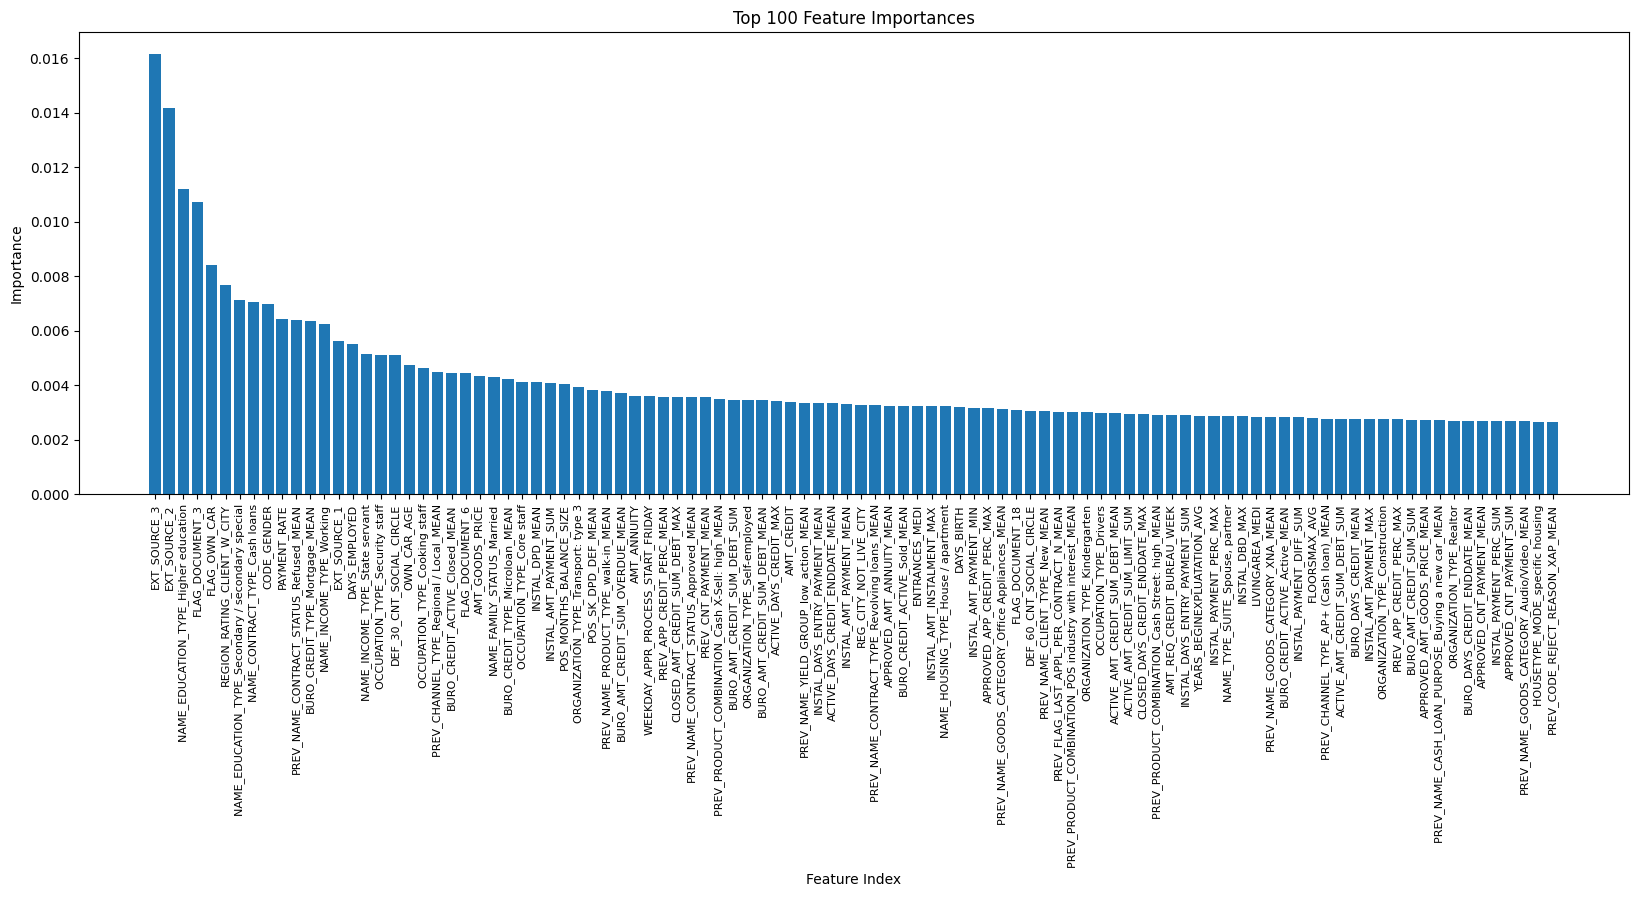

In [31]:
# Sélectionner les 100 caractéristiques les plus importantes
top_100_features = importance_df.head(100)

# Tracer le graphique
plt.figure(figsize=[20,6])
plt.bar(top_100_features['feature'], top_100_features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 100 Feature Importances')
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [32]:
importance_df[0:101]

,feature,importance
34,EXT_SOURCE_3,0.016145
33,EXT_SOURCE_2,0.014186
130,NAME_EDUCATION_TYPE_Higher education,0.011201
84,FLAG_DOCUMENT_3,0.010707
3,FLAG_OWN_CAR,0.008395
...,...,...
538,APPROVED_CNT_PAYMENT_SUM,0.002681
440,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,0.002680
241,HOUSETYPE_MODE_specific housing,0.002668
425,PREV_CODE_REJECT_REASON_XAP_MEAN,0.002661


In [33]:
# Calculer le taux de NA pour chaque colonne et fusionner avec les importances
na_info = pd.DataFrame({
    'feature': df_cleaned1.columns,
    'NA Rate': df_cleaned1.isna().mean() * 100 # Multiplié par 100 pour avoir un pourcentage
}).merge(importance_df, on='feature')

# Trier par taux de NA
na_info = na_info.sort_values(by='NA Rate')

# Obtenir le rang d'importance
na_info['Importance Ranking'] = na_info['importance'].rank(ascending=False)

# Initialiser le résumé
na_summary = []

# Itérer sur chaque taux de NA unique
for na_rate in na_info['NA Rate'].unique():
    # Obtenir les lignes avec ce taux de NA
    rows_with_na_rate = na_info[na_info['NA Rate'] == na_rate]

    # Obtenir le nombre de colonnes, le rang d'importance le plus bas et le nombre de lignes restantes
    summary_row = {
        'NA Rate': na_rate,
        'Number of Columns': len(rows_with_na_rate),
        'Lowest Importance Ranking': rows_with_na_rate['Importance Ranking'].min(),
        'Remaining Rows': len(df_cleaned.dropna(subset=rows_with_na_rate['feature']))
    }

    # Ajouter au résumé
    na_summary.append(summary_row)

# Convertir le résumé en DataFrame
na_summary_df = pd.DataFrame(na_summary)

# Afficher le DataFrame
na_summary_df



,NA Rate,Number of Columns,Lowest Importance Ranking,Remaining Rows
0,0.000000,260,1.0,356194
1,5.160879,24,28.0,339526
2,5.351143,163,11.0,338797
3,5.385944,2,277.0,338554
4,5.424972,3,37.0,338545
5,5.673780,20,53.0,337638
6,5.676707,3,60.0,337629
7,5.875753,17,30.0,337192
8,14.314382,46,12.0,305759
9,25.151317,20,38.0,267882


In [34]:
# Initialiser le résumé
na_summary = []

# Itérer sur chaque taux de NA unique
for na_rate in na_info['NA Rate'].unique():
    # Obtenir les lignes avec ce taux de NA
    rows_with_na_rate = na_info[na_info['NA Rate'] == na_rate]

    # Obtenir les colonnes avec ce taux de NA
    columns_with_na_rate = rows_with_na_rate['feature'].tolist()

    # Calculer le nombre de lignes où au moins une de ces colonnes est NA
    involved_rows_count = df_cleaned1[columns_with_na_rate].isna().any(axis=1).sum()

    # Obtenir le nombre de colonnes, le rang d'importance le plus bas et le nombre de lignes impliquées
    summary_row = {
        'NA Rate': na_rate,
        'Number of Columns': len(rows_with_na_rate),
        'Lowest Importance Ranking': rows_with_na_rate['Importance Ranking'].min(),
        'Involved Rows': involved_rows_count,
        'Liste': f'Colonne {len(na_summary)}'
    }

    # Ajouter au résumé
    na_summary.append(summary_row)

# Convertir le résumé en DataFrame
na_summary_df = pd.DataFrame(na_summary)

# Créer un dictionnaire pour stocker les listes de colonnes
column_lists = {}
for i, row in na_summary_df.iterrows():
    na_rate = row['NA Rate']
    columns_with_na_rate = na_info[na_info['NA Rate'] == na_rate]['feature'].tolist()
    column_lists[row['Liste']] = columns_with_na_rate

# Vous pouvez maintenant utiliser 'column_lists["Colonne 0"]' pour obtenir la liste des colonnes pour le taux de NA 0.00000, etc.

# Afficher le DataFrame
na_summary_df

,NA Rate,Number of Columns,Lowest Importance Ranking,Involved Rows,Liste
0,0.000000,260,1.0,0,Colonne 0
1,5.160879,24,28.0,15868,Colonne 1
2,5.351143,163,11.0,16453,Colonne 2
3,5.385944,2,277.0,16560,Colonne 3
4,5.424972,3,37.0,16680,Colonne 4
5,5.673780,20,53.0,17445,Colonne 5
6,5.676707,3,60.0,17454,Colonne 6
7,5.875753,17,30.0,18066,Colonne 7
8,14.314382,46,12.0,44012,Colonne 8
9,25.151317,20,38.0,77332,Colonne 9


In [35]:
# Trouver les colonnes associées à "Colonne 14" et "Colonne 13"
cr1 = column_lists['Colonne 14']
cr1 += column_lists['Colonne 13']
cr1 += column_lists['Colonne 12']
cr1 += column_lists['Colonne 11']
cr1 += column_lists['Colonne 10']
cr1 += column_lists['Colonne 9']
cr1 += column_lists['Colonne 6']
cr1 += column_lists['Colonne 4']
cr1 += column_lists['Colonne 3']

# Combiner ces deux listes de colonnes
columns_to_remove = cr1

# Supprimer ces colonnes de df_cleaned
df3 = df_cleaned.drop(columns=columns_to_remove)


In [36]:
df3.isna().sum()

index                                 0
SK_ID_CURR                            0
TARGET                            48727
CODE_GENDER                           0
FLAG_OWN_CAR                          0
                                  ...  
INSTAL_AMT_PAYMENT_SUM            16668
INSTAL_DAYS_ENTRY_PAYMENT_MAX     16668
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    16668
INSTAL_DAYS_ENTRY_PAYMENT_SUM     16668
INSTAL_COUNT                      16668
Length: 531, dtype: int64

In [37]:
# Sélectionnez toutes les colonnes sauf 'TARGET'
columns_to_check = [col for col in df3.columns if col != 'TARGET']

# Supprimez les lignes contenant des valeurs NA dans les colonnes sélectionnées
df4 = df3.dropna(subset=columns_to_check)

In [38]:
df4.isna().sum().sum()

41296

In [39]:
df4.shape

(288016, 531)

In [40]:
final = "/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/df4.csv"
df4.to_csv(final, index=False)

<h1 align=center>PARAMETRAGE NO-NAN</h1>

In [41]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne (hors 'TARGET')
na_percentage = df_final.drop(columns=['TARGET']).isna().mean().sort_values(ascending=False) * 100

# Créer un DataFrame pour visualiser les résultats
na_pareto_df = pd.DataFrame({
    'Column': na_percentage.index,
    'NA Percentage': na_percentage.values
})

In [42]:
# Afficher le résultat
na_pareto_df[0:51]

,Column,NA Percentage
0,CLOSED_DAYS_CREDIT_VAR,42.111602
1,APPROVED_APP_CREDIT_PERC_VAR,30.078553
2,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,29.315485
3,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,29.315485
4,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,29.315485
5,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,29.315485
6,ACTIVE_CNT_CREDIT_PROLONG_SUM,29.315485
7,ACTIVE_MONTHS_BALANCE_SIZE_SUM,29.315485
8,ACTIVE_DAYS_CREDIT_MIN,29.315485
9,ACTIVE_DAYS_CREDIT_MAX,29.315485


In [43]:
# Calculer le nombre de lignes impliquées pour chaque colonne
na_pareto_df['Involved Rows'] = (na_pareto_df['NA Percentage'] / 100) * len(df_final)

# Grouper les données par le pourcentage de valeurs manquantes (NA) et calculer le nombre de colonnes et les lignes impliquées
aggregated_data = na_pareto_df.groupby('NA Percentage').agg(
    Number_of_Columns=pd.NamedAgg(column='Column', aggfunc='count'),
    Involved_Rows=pd.NamedAgg(column='Involved Rows', aggfunc='sum')
).reset_index()

# Afficher le résultat
print(aggregated_data)

    NA Percentage  Number_of_Columns  Involved_Rows
0        0.000000                260            0.0
1        4.679472                 24       400032.0
2        4.884136                163      2835711.0
3        4.952357                  2        35280.0
4        4.954884                  3        52947.0
5        5.209521                 20       371120.0
6        5.212047                  3        55695.0
7        5.334733                 17       323034.0
8       14.159419                 46      2320010.0
9       24.793231                 20      1766240.0
10      24.825516                  1        88427.0
11      25.814303                  1        91949.0
12      29.315485                 20      2088400.0
13      30.078553                  1       107138.0
14      42.111602                  1       149999.0


In [45]:
# Identifier les colonnes avec un taux de valeurs manquantes supérieur à 10 %, hors 'TARGET'
columns_to_drop = na_pareto_df[na_pareto_df['NA Percentage'] > 10]['Column'].tolist()

# Assurez-vous que 'TARGET' n'est pas dans la liste des colonnes à supprimer
if 'TARGET' in columns_to_drop:
    columns_to_drop.remove('TARGET')

# Supprimer ces colonnes du DataFrame d'origine
df_final1 = df_final.drop(columns=columns_to_drop)

# Supprimer les lignes avec des valeurs manquantes dans les colonnes restantes, sauf 'TARGET'
df_final1 = df_final1.dropna(subset=[col for col in df_final1.columns if col != 'TARGET'])

In [46]:
df_final1.shape

(334329, 493)

In [51]:
final = "/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/dfclean_targetnan.csv"
df_final1.to_csv(final, index=False)

In [47]:
missing_counts_per_column = df_final1.isna().sum()
# Filtrer les colonnes avec au moins une valeur manquante
columns_with_na = missing_counts_per_column[missing_counts_per_column > 0]
columns_with_na

TARGET    47208
dtype: int64

In [48]:
df_nonan = df_final1.dropna(axis=0)

In [50]:
final = "/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/df_nonan.csv"
df_nonan.to_csv(final, index=False)

In [49]:
df_nonan.shape

(287121, 493)